The purpose of this notebook is to simulate a simple L or M band imaging observation with METIS. Some extra cells demonstrate functions of SimMETIS. They are marked with "INFO" and can be deleted without affecting the outcome of the simulation.

In [1]:
import numpy as np
from astropy.modeling.blackbody import blackbody_lambda
from astropy import units as u
from astropy import constants as const
import simmetis as sim
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Number of photons on the detector

In [2]:
# Load the configuration file for the LM imaging mode of METIS.
#    Have a look at the config file (in the same directory as this notebook);
#    it is documented and should be self-explanatory
cmd = sim.UserCommands("metis_image_LM.config")

# filter transmission curves are stored in ../data (the SIM_DATA_DIR as set in the config file given above)
metis_filter_id="Lp"
cmd["INST_FILTER_TC"]="TC_filter_" + metis_filter_id + ".dat"

In [4]:
# INFO -- show list of commands
cmd.cmds

OrderedDict([('OBS_DATE', 0.0),
             ('OBS_TIME', 0.0),
             ('OBS_RA', 90.0),
             ('OBS_DEC', -30.0),
             ('OBS_ALT', 0.0),
             ('OBS_AZ', 0.0),
             ('OBS_ZENITH_DIST', 0.0),
             ('OBS_PARALLACTIC_ANGLE', 0.0),
             ('OBS_SEEING', 0.6),
             ('OBS_FIELD_ROTATION', 0.0),
             ('OBS_EXPTIME', 1.0),
             ('OBS_NDIT', 1.0),
             ('OBS_NONDESTRUCT_TRO', 2.6),
             ('OBS_REMOVE_CONST_BG', 'no'),
             ('OBS_READ_MODE', 'single'),
             ('OBS_SAVE_ALL_FRAMES', 'no'),
             ('OBS_INPUT_SOURCE_PATH', None),
             ('OBS_FITS_EXT', 0.0),
             ('OBS_OUTPUT_DIR', '"./output.fits"'),
             ('SIM_DATA_DIR', '../data/'),
             ('SIM_DETECTOR_PIX_SCALE', 0.00525),
             ('SIM_OVERSAMPLING', 1.0),
             ('SIM_PIXEL_THRESHOLD', 1.0),
             ('SIM_LAM_TC_BIN_WIDTH', 0.001),
             ('SIM_SPEC_MIN_STEP', 0.0001),
           

In [6]:
# build the optical train (re-samples transmission curves etc. to the required resolution and takes a moment)
#   With the default PSF this currently produces a UserWarning that can be ignored.
opt = sim.OpticalTrain(cmd)

/usr/local/Cellar/python3/3.6.1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/simmetis/psf.py:1200: UserWarning: CDELT > 1. Assuming the scale to be [mas]
  warnings.warn("CDELT > 1. Assuming the scale to be [mas]")


In [9]:
# initialise a detector object: This holds the detector layout and QE curve 
#    and will later be used to add Poisson noise to the incoming photon-field.
fpa = sim.Detector(cmd, small_fov=False)

In [10]:
## generate a source with 0 mag and dither
lam, spec = sim.source.flat_spectrum(0, "TC_filter_" + metis_filter_id + ".dat")

src = sim.Source(lam=lam, spectra=np.array([spec]), 
                 ref=[0], x=[0], y=[0])

dither_offset=1 ## offsets in arcseconds
src_dither = sim.Source(lam=lam, spectra=np.array([spec]), 
                 ref=[0], x=[0], y=[dither_offset])

In [11]:
# Apply the transmission curves etc. to the source object, read out the detector / construct a FITS HDU object
#    We repeat this for the nominal position and the dither position to simulate a dithered observation.
src.apply_optical_train(opt, fpa)
hdu = fpa.read_out()
src_dither.apply_optical_train(opt,fpa)
hdu_dither = fpa.read_out()

Generating image for chip 1
Reading out chip 1 using superfast
1.28313166311e+12 263365.718645 6349571535.61 263479.31715
1.28313e+12 260863.0 6.34952e+09 263688.0
Generating image for chip 1
Reading out chip 1 using superfast
1.28313166311e+12 263365.718645 6349571535.61 263479.31715
1.28313e+12 260913.0 6.34958e+09 263687.0


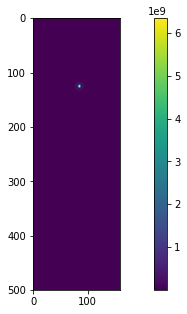

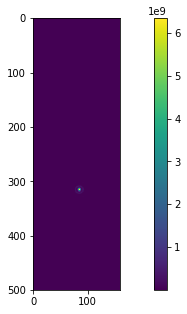

In [14]:
## Let's have a look at our object
##
## Nominal position
plt.figure(figsize=(12,5))
frame1=hdu[0].data
plt.imshow(frame1[900:1400,940:1100], interpolation="none")
plt.colorbar()
##
## Dither position (frame 2)
plt.figure(figsize=(12,5))
frame2=hdu_dither[0].data
plt.imshow(frame2[900:1400,940:1100], interpolation="none")
plt.colorbar()

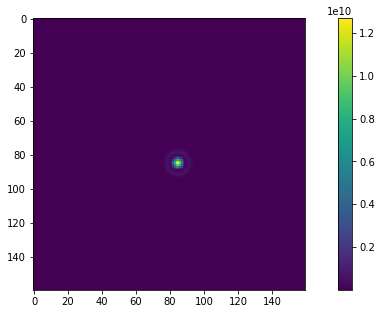

In [18]:
## Shift the dithered image back to the original position and combine the two images
##    This is the final result for this simulation.
frame_sum=frame1+np.roll(frame2,np.int(np.round(-dither_offset/cmd["SIM_DETECTOR_PIX_SCALE"])),axis=0)
plt.figure(figsize=(12,5))
plt.imshow(frame_sum[940:1100,940:1100])
plt.colorbar()